OUTDATED CODE for determination of partial contributions of hadrons (better version in variable_angle+plotter)
------------------------------------------------------------------------

This notebook reproduces Figure 9 from the proceedings arXiv:1503.00544.

This updated version uses SIBYLL 2.3c. Results might be therefore slightly different.


In [1]:
#basic imports and ipython setup
%load_ext autoreload
%matplotlib inline
%autoreload 2
import os
import sys

import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np

sys.path.append('../MCEq')
os.chdir('..')

#import solver related modules
#import primary model choices
import crflux.models as pm

from MCEq.core import MCEqRun
from mceq_config import config
from MCEq.particlemanager import MCEqParticle

/tmp/ipykernel_1266571/2567319151.py:20: DeprecationWarning: The module 'mceq_config' has been moved to 'MCEq.config'. Please update your `import mceq_config` to `import MCEq.config` accordingly.
  from mceq_config import config


In [2]:
config.compact_mode = False
config.low_energy_extension['enable'] = True
config.store_solution = True

# Point to the folder containing the new db
config.data_dir = "/scratch/nbenton/project/lib/python3.11/site-packages/MCEq/data"

# Override the HDF5 filename (so MCEq doesn’t pick lext by default)
config.mceq_db_fname = "mceq_db_fine_v150.h5"
#config.db_fname = "mceq_db_lext_dpm193_v150.h5"


{}

In [3]:
mceq_run = MCEqRun(
#provide the string of the interaction model
interaction_model='SIBYLL23C',
#support a tuple (primary model class (not instance!), arguments)
primary_model=(pm.HillasGaisser2012, 'H3a'),
# [degrees] 0=vertical, 90=horizontal
theta_deg=60,
interaction_medium = 'air',
**config
)
mceq_run.set_density_model(('MSIS00_IC', ('SouthPole', "October")))
mag = 3
pman = mceq_run.pman

MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): HillasGaisser2012 H3a
MCEqRun::set_density_model(): Setting density profile to MSIS00_IC ('SouthPole', 'October')
MSIS00IceCubeCentered::set_theta(): latitude = -90.00 for zenith angle = 60.00


In [14]:
from mceq_config import config
import os

print("MCEq data directory:", config.data_dir)
print("HDF5 file name:     ", config.mceq_db_fname)
print("Full path in use:   ", os.path.join(config.data_dir, config.mceq_db_fname))

MCEq data directory: /scratch/nbenton/project/lib/python3.11/site-packages/MCEq/data
HDF5 file name:      mceq_db_fine_v150.h5
Full path in use:    /scratch/nbenton/project/lib/python3.11/site-packages/MCEq/data/mceq_db_fine_v150.h5


In [15]:
proton_parents = [(2212,0), (-2212,0)]
lepton_children = {
    (13,   0): 'mu-',       # μ⁻
    (-13,  0): 'mu+',       # μ⁺
    (14,   0): 'numu',      # νµ
    (-14,  0): 'antinumu',  # ν̄µ
    (12,   0): 'nue',       # νe
    (-12,  0): 'antinue',   # ν̄e
    (16,   0): 'nutau',     # ντ
    (-16,  0): 'antinutau', # ν̄τ
}
for child_pdg, suffix in lepton_children.items():
    alias = f"p_{suffix}"
    pman.add_tracking_particle(
        proton_parents,
        child_pdg,
        alias,
        from_interactions=True
    )

In [16]:
mceq_run.solve()

# Conventional Component
mu_conv = mceq_run.get_solution('conv_mu+', mag) + \
          mceq_run.get_solution('conv_mu-', mag)

numu_conv = mceq_run.get_solution('conv_numu', mag) + \
            mceq_run.get_solution('conv_antinumu', mag)

nue_conv = mceq_run.get_solution('conv_nue', mag) + \
           mceq_run.get_solution('conv_antinue', mag)

# Prompt Component
mu_prompt = mceq_run.get_solution('pr_mu+', mag) + \
          mceq_run.get_solution('pr_mu-', mag)

numu_prompt = mceq_run.get_solution('pr_numu', mag) + \
            mceq_run.get_solution('pr_antinumu', mag)

nue_prompt = mceq_run.get_solution('pr_nue', mag) + \
           mceq_run.get_solution('pr_antinue', mag)

# Total Component
mu_total = mceq_run.get_solution('total_mu+', mag) + \
           mceq_run.get_solution('total_mu-', mag)

numu_total = mceq_run.get_solution('total_numu', mag) + \
            mceq_run.get_solution('total_antinumu', mag)

nue_total = mceq_run.get_solution('total_nue', mag) + \
            mceq_run.get_solution('total_antinue', mag)

nutau_total = mceq_run.get_solution('total_nutau', mag) + \
              mceq_run.get_solution('total_antinutau', mag)

In [17]:
# Re-apply the appropriate databases, hopefully initializes the tables for our added particles
pman.set_cross_sections_db(mceq_run._int_cs)
pman.set_decay_channels(mceq_run._decays)
pman.set_interaction_model(mceq_run._int_cs, mceq_run._interactions)

In [18]:
print("Aliases in pman after proton tracking:", 
      sorted([name for name in pman.pname2pref if name.startswith("p_")]))

# B) How many tracking-relations were recorded?
print("Tracking relations (parent→child):")
for rel in pman.tracking_relations:
    print(" ", rel)

# C) What are proton’s direct hadronic secondaries?
prot = pman.pdg2pref[(2212,0)]
print("Proton hadronic secondaries (names):", 
      [c.name for c in prot.hadr_secondaries])

# D) For each new alias, what mceq index was assigned?
for name in sorted(pman.pname2mceqidx):
    if name.startswith("p_"):
        idx = pman.pname2mceqidx[name]
        print(f"  alias {name!r} → mceqidx {idx}")

Aliases in pman after proton tracking: ['p_antinue', 'p_antinumu', 'p_mu+', 'p_mu-', 'p_nue', 'p_numu']
Tracking relations (parent→child):
  ((-211, 0), (-12, np.int64(0)), 'pi_antinue', False)
  ((211, 0), (12, np.int64(0)), 'pi_nue', False)
  ((211, 0), (-13, np.int64(-1)), 'pi_mu+_l', False)
  ((211, 0), (-13, np.int64(1)), 'pi_mu+_r', False)
  ((-211, 0), (13, np.int64(-1)), 'pi_mu-_l', False)
  ((-211, 0), (13, np.int64(1)), 'pi_mu-_r', False)
  ((-211, 0), (-14, np.int64(0)), 'pi_antinumu', False)
  ((211, 0), (14, np.int64(0)), 'pi_numu', False)
  ((-321, 0), (-12, np.int64(0)), 'k_antinue', False)
  ((321, 0), (12, np.int64(0)), 'k_nue', False)
  ((321, 0), (-13, np.int64(-1)), 'k_mu+_l', False)
  ((321, 0), (-13, np.int64(1)), 'k_mu+_r', False)
  ((-321, 0), (13, np.int64(-1)), 'k_mu-_l', False)
  ((-321, 0), (13, np.int64(1)), 'k_mu-_r', False)
  ((-321, 0), (-14, np.int64(0)), 'k_antinumu', False)
  ((321, 0), (14, np.int64(0)), 'k_numu', False)
  ((13, -1), (-12, np.int64(0

In [19]:
parent_groups = [
    ([(411, 0), (-411, 0)], 'Dpm'),                     # D+ and D-
    ([(421, 0), (-421, 0)], 'D0'),                      # D0 and anti-D0
    ([(431, 0), (-431, 0)], 'Ds'),                      # Ds+ and Ds-
    ([(321, 0), (-321, 0)], 'Kpm'),                     # K+ and K-
    ([(310, 0)], 'K0s'),                                # K0s
    ([(130, 0)], 'K0L'),                                # K0L
    ([(211, 0), (-211, 0)], 'Pion'),                    # pi+ and pi-
    ([(4122, 0), (-4122, 0)], 'LambdaC'),               # Lambda_c+ and anti-Lambda_c
    ([(111, 0), (221, 0), (331, 0)], 'Unflavoured'),    # π0, η, η′
    ([(15, 0), (-15, 0),(15, -1), (-15, -1),(15, 1), (-15, 1)], 'Tau'),                       # Tau+ and Tau-
    ([(13, 0), (-13, 0),(13, 1),
      (-13, 1),(13, -1), (-13, -1)], 'Muon'),           # Muon+ and Muon- (MUON DECAY)
]

#[(15, 0), (-15, 0),(15, -1), (-15, -1),(15, 1), (-15, 1)], 'Tau'),
#    ([(2212, 0)], 'Proton'),

In [28]:
# 1) Register ALL parent→lepton tracking once
for pdg_list, label in parent_groups:
    pman.track_leptons_from(
        parent_pdg_list=pdg_list,
        prefix=f"{label}_",
        exclude_em=True,
        use_helicities=False,
    )

#print("Aliases in particle manager:", sorted(mceq_run.pman.pname2mceqidx.keys()))

# 2) Rebuild MCEq’s transport matrices ONCE
mceq_run._resize_vectors_and_restore()
mceq_run.regenerate_matrices()

mceq_run.solve()

# 4) Now extract into your dicts WITHOUT any more solves
mu_obs    = {}
numu_obs  = {}
nue_obs   = {}
nutau_obs = {}

for pdg_list, label in parent_groups:

    # Muons (μ⁻ + μ⁺)
    mu_obs[label] = (
        mceq_run.get_solution(f"{label}_mu-", mag)
      + mceq_run.get_solution(f"{label}_mu+", mag)
    )

    # Muon-neutrinos (νμ + ν̄μ)
    numu_obs[label] = (
        mceq_run.get_solution(f"{label}_numu",     mag)
      + mceq_run.get_solution(f"{label}_antinumu", mag)
    )

    # Electron-neutrinos (νe + ν̄e)
    nue_obs[label] = (
        mceq_run.get_solution(f"{label}_nue",     mag)
      + mceq_run.get_solution(f"{label}_antinue", mag)
    )

    # Tau-neutrinos (ντ + ν̄τ)
    nutau_obs[label] = (
        mceq_run.get_solution(f"{label}_nutau",      mag)
      + mceq_run.get_solution(f"{label}_antinutau", mag)
    )

mu_obs['Pion'] = (
      mceq_run.get_solution('pi_mu+_l', mag) + mceq_run.get_solution('pi_mu+_r', mag)
      + mceq_run.get_solution('pi_mu-_l', mag) + mceq_run.get_solution('pi_mu-_r', mag)
    )
mu_obs['Kpm'] = (
      mceq_run.get_solution('k_mu+_l', mag) + mceq_run.get_solution('k_mu+_r', mag)
      + mceq_run.get_solution('k_mu-_l', mag) + mceq_run.get_solution('k_mu-_r', mag)
    )

flux_p_numu = mceq_run.get_solution('p_numu', mag) \
               + mceq_run.get_solution('p_antinumu', mag)
flux_p_nue = mceq_run.get_solution('p_nue', mag) \
               + mceq_run.get_solution('p_antinue', mag)
flux_p_nutau = mceq_run.get_solution('p_nutau', mag) \
               + mceq_run.get_solution('p_antinutau', mag)
flux_p_mu = mceq_run.get_solution('p_mu+', mag) \
            + mceq_run.get_solution('p_mu-', mag)

MCEqRun::set_primary_model(): HillasGaisser2012 H3a


In [29]:
nutau_obs['Tau']

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

In [21]:
print("Aliases in particle manager:", sorted(mceq_run.pman.pname2mceqidx.keys()))

Aliases in particle manager: ['D+', 'D-', 'D0', 'D0_antinue', 'D0_antinumu', 'D0_mu+', 'D0_mu-', 'D0_nue', 'D0_numu', 'D_s+', 'D_s-', 'Dbar0', 'Dpm_antinue', 'Dpm_antinumu', 'Dpm_antinutau', 'Dpm_mu+', 'Dpm_mu-', 'Dpm_nue', 'Dpm_numu', 'Dpm_nutau', 'Ds_antinue', 'Ds_antinumu', 'Ds_antinutau', 'Ds_mu+', 'Ds_mu-', 'Ds_nue', 'Ds_numu', 'Ds_nutau', 'K+', 'K-', 'K0L_antinue', 'K0L_antinumu', 'K0L_mu+', 'K0L_mu-', 'K0L_nue', 'K0L_numu', 'K0_antinue', 'K0_antinumu', 'K0_mu+', 'K0_mu-', 'K0_nue', 'K0_numu', 'K0s_antinue', 'K0s_nue', 'K_L0', 'K_S0', 'Kpm_antinue', 'Kpm_antinumu', 'Kpm_nue', 'Kpm_numu', 'Lambda0', 'Lambdabar0', 'Muon_antinue', 'Muon_antinumu', 'Muon_nue', 'Muon_numu', 'Pion_antinue', 'Pion_antinumu', 'Pion_nue', 'Pion_numu', 'antinue', 'antinumu', 'antinutau', 'e+', 'e-', 'gamma', 'k_antinue', 'k_antinumu', 'k_mu+_l', 'k_mu+_r', 'k_mu-_l', 'k_mu-_r', 'k_nue', 'k_numu', 'mu+', 'mu+_l', 'mu+_r', 'mu-', 'mu-_l', 'mu-_r', 'mu_antinue', 'mu_antinumu', 'mu_h0_antinue', 'mu_h0_antinumu

In [23]:
parents = [p for p in pman.all_particles]
print([p.name for p in parents])

['e+', 'e-', 'antinue', 'nue', 'mu+_l', 'mu+', 'mu+_r', 'mu-_l', 'mu-', 'mu-_r', 'antinumu', 'numu', 'antinutau', 'nutau', 'gamma', 'pi0', 'K_L0', 'pi-', 'pi+', 'K_S0', 'K-', 'K+', 'D-', 'D+', 'Dbar0', 'D0', 'D_s-', 'D_s+', 'nbar0', 'n0', 'pbar-', 'p+', 'Lambdabar0', 'Lambda0', 'pi_antinue', 'pi_nue', 'pi_mu+_l', 'pi_mu+_r', 'pi_mu-_l', 'pi_mu-_r', 'pi_antinumu', 'pi_numu', 'k_antinue', 'k_nue', 'k_mu+_l', 'k_mu+_r', 'k_mu-_l', 'k_mu-_r', 'k_antinumu', 'k_numu', 'mulr_antinue', 'mulr_nue', 'mulr_antinumu', 'mulr_numu', 'mu_h0_antinue', 'mu_h0_nue', 'mu_h0_antinumu', 'mu_h0_numu', 'mu_antinue', 'mu_nue', 'mu_antinumu', 'mu_numu', 'K0_antinue', 'K0_nue', 'K0_mu+', 'K0_mu-', 'K0_antinumu', 'K0_numu', 'prcas_antinue', 'prcas_nue', 'prcas_mu+', 'prcas_mu-', 'prcas_antinumu', 'prcas_numu', 'prcas_antinutau', 'prcas_nutau', 'prres_antinue', 'prres_nue', 'prres_mu+', 'prres_mu-', 'prres_antinumu', 'prres_numu', 'Dpm_antinue', 'Dpm_nue', 'Dpm_mu+', 'Dpm_mu-', 'Dpm_antinumu', 'Dpm_numu', 'Dpm_an

In [24]:
# Optional: nice LaTeX-style labels for source names
label_map = {
    'Dpm': r'$D^\pm$',                                  # D+ and D-
    'D0': r'$D^0$',                                     # D0 and anti-D0
    'Ds': r'$D_s$',                                     # Ds+ and Ds-
    'Kpm': r'$K^\pm$',                                  # K+ and K-
    'K0s': r'$K^0_S$',                                  # K0 short
    'K0L': r'$K^0_L$',                                  # K0 long
    'Pion': r'$\pi^\pm$',                               # pi+ and pi-
    'LambdaC': r'$\Lambda_c$',                          # Lambda_c+ and anti-Lambda_c
    'Unflavoured': r'unflavoured',                      # neutral unflavoured mesons
    'Tau': r'$\tau^\pm$',                               # Tau+ and Tau-
    'Muon': r'muon decay',                              # Muon+ and Muon-
}

# Map each particle to a fixed color
color_map = {
    'Dpm': 'cyan',
    'D0': 'blue',
    'Ds': 'cornflowerblue',
    'Kpm': 'green',
    'K0s': 'lime',
    'K0L': 'olive',
    'Pion': 'red',
    'LambdaC': 'purple',
    'Unflavoured': 'orange',
    'Tau': 'gold',
    'Muon': 'magenta',
}


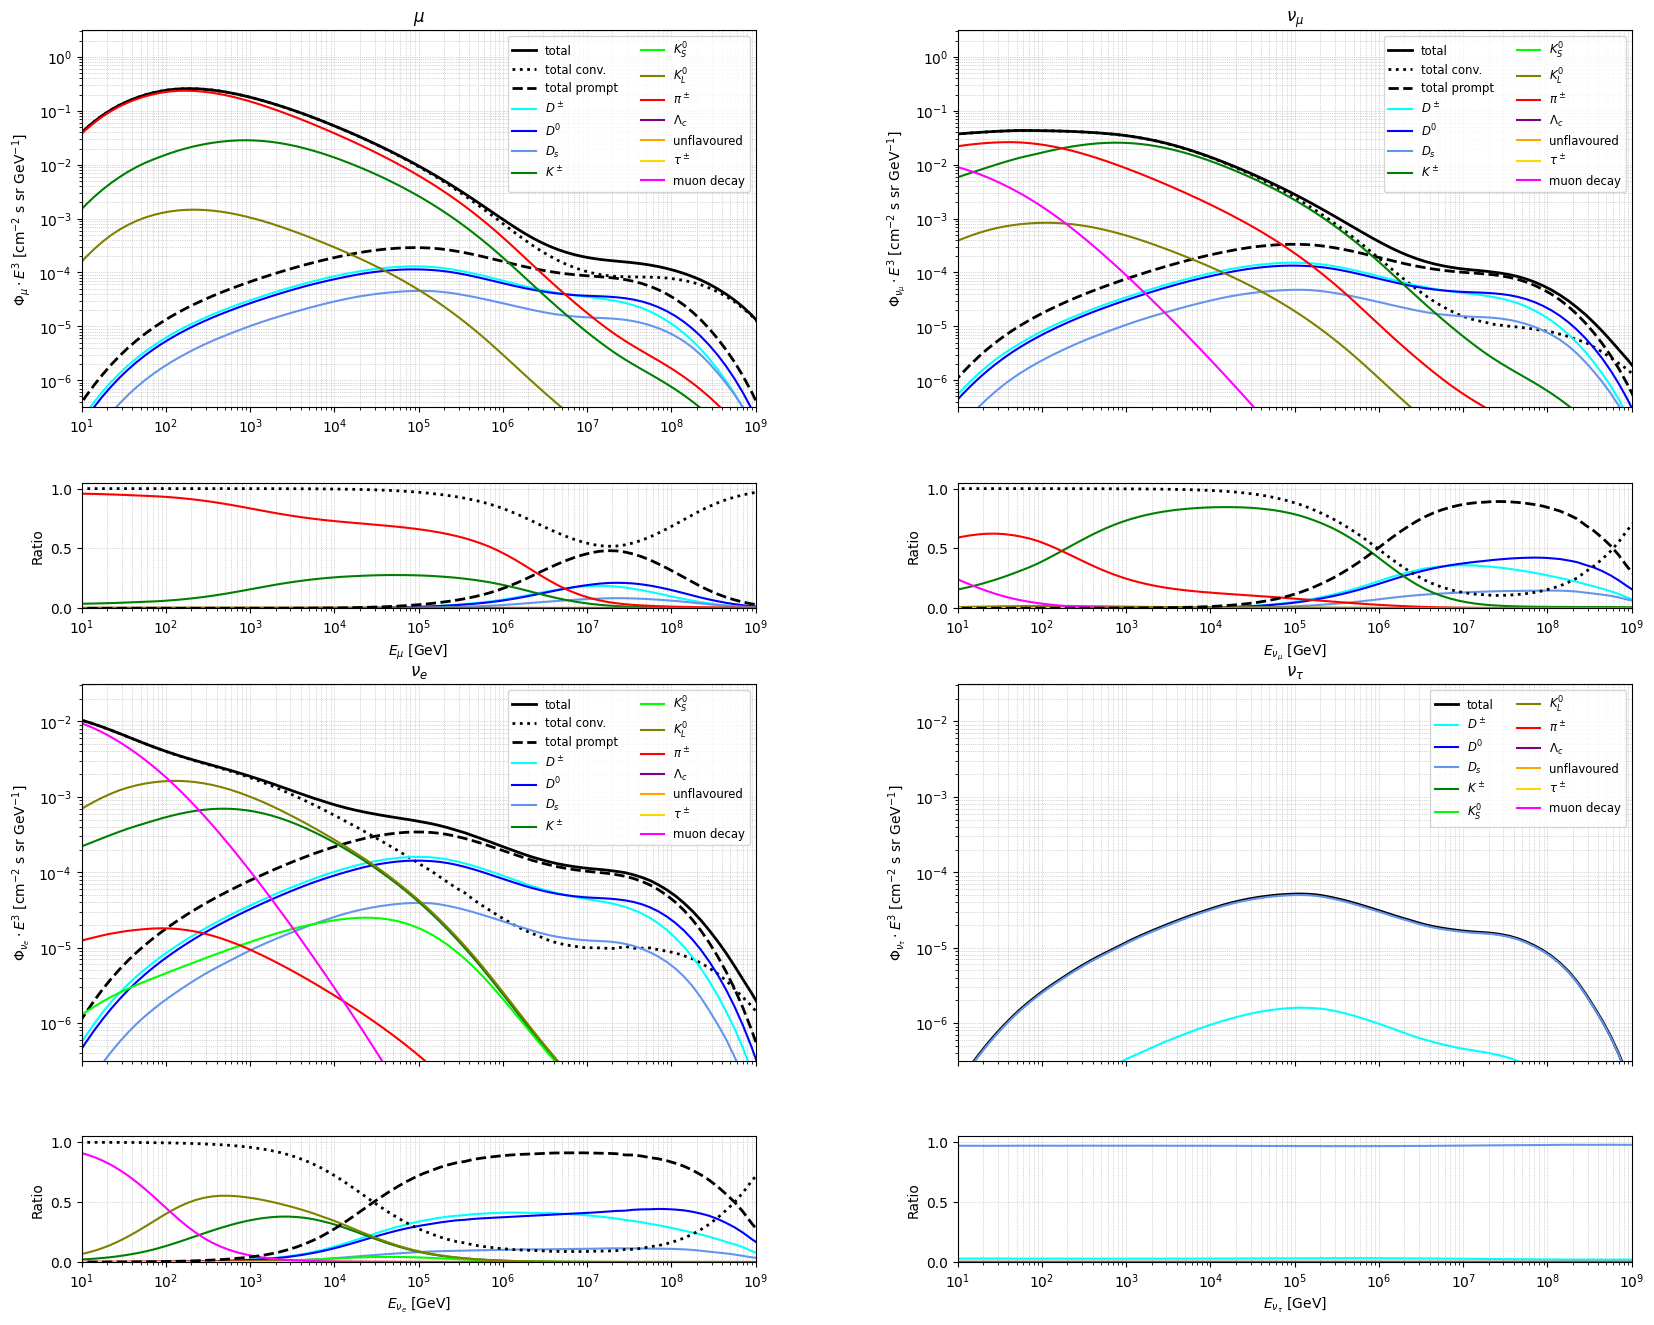

In [25]:
fig = plt.figure(figsize=(20, 16))
gs = gridspec.GridSpec(4, 2, height_ratios=[3, 1]*2, hspace=0.3, wspace=0.3)

e_grid = mceq_run.e_grid

# ---------- MUONS ----------
ax_mu = fig.add_subplot(gs[0, 0])
ax_mu.set_title(r"$\mu$")
ax_mu.plot(e_grid, mu_total, ls='-', lw=2, color='black', label='total')
ax_mu.plot(e_grid, mu_conv, ls='dotted', lw=2, color='black', label='total conv.')
ax_mu.plot(e_grid, mu_prompt, ls='--', lw=2, color='black', label='total prompt')

for key, flux in mu_obs.items():
    ax_mu.plot(e_grid, flux, ls='-', lw=1.5, color=color_map.get(key, 'black'),
               label=label_map.get(key, key))

ax_mu.set_xscale('log')
ax_mu.set_yscale('log')
ax_mu.set_xlim([10, 1e9])
ax_mu.set_ylim([10**(-6.5), 10**(0.5)])
ax_mu.set_ylabel(r"$\Phi_{{\mu}} \cdot E^{{{}}}$".format(mag) + r" [cm$^{-2}$ s sr GeV$^{-1}$]")
ax_mu.legend(loc='upper right', fontsize='small', ncol=2, frameon=True)
ax_mu.grid(True, which='both', ls=':', lw=0.5)


# Ratio subplot
ax_mu_ratio = fig.add_subplot(gs[1, 0], sharex=ax_mu)
for key, flux in mu_obs.items():
    ratio = np.divide(flux, mu_total, out=np.zeros_like(flux), where=mu_total > 0)
    ax_mu_ratio.plot(e_grid, ratio, ls='-', lw=1.5, color=color_map.get(key, 'black'),
                     label=label_map.get(key, key))

ax_mu_ratio.plot(e_grid, mu_conv/mu_total, ls='dotted', lw=2, color='black')
ax_mu_ratio.plot(e_grid, mu_prompt/mu_total, ls='--', lw=2, color='black')
ax_mu_ratio.set_xscale('log')
ax_mu_ratio.set_xlabel(r"$E_{\mu}$ [GeV]")
ax_mu_ratio.set_ylabel("Ratio")
ax_mu_ratio.set_ylim([0, 1.05])
ax_mu_ratio.grid(True, which='both', ls=':', lw=0.5)

# ---------- MUON NEUTRINOS ----------
ax_numu = fig.add_subplot(gs[0, 1])
ax_numu.set_title(r"$\nu_{\mu}$")
ax_numu.plot(e_grid, numu_total, ls='-', lw=2, color='black', label='total')

# Optional conv/prompt components
ax_numu.plot(e_grid, numu_conv, ls='dotted', lw=2, color='black', label='total conv.')
ax_numu.plot(e_grid, numu_prompt, ls='--', lw=2, color='black', label='total prompt')

# Plot subcomponents
for key, flux in numu_obs.items():
    ax_numu.plot(e_grid, flux, ls='-', lw=1.5, color=color_map.get(key, 'black'),
                 label=label_map.get(key, key))

ax_numu.set_xscale('log')
ax_numu.set_yscale('log')
ax_numu.set_xlim([10, 1e9])
ax_numu.set_ylim([10**(-6.5), 10**(0.5)])
ax_numu.set_ylabel(r"$\Phi_{{\nu_{{\mu}}}} \cdot E^{{{}}}$".format(mag) + r" [cm$^{-2}$ s sr GeV$^{-1}$]")
ax_numu.legend(loc='upper right', fontsize='small', ncol=2, frameon=True)
ax_numu.grid(True, which='both', ls=':', lw=0.5)
plt.setp(ax_numu.get_xticklabels(), visible=False)  # hide x-axis ticks for upper plot

# ---------- RATIO: Subcomponents / Total ----------
ax_numu_ratio = fig.add_subplot(gs[1, 1], sharex=ax_numu)

for key, flux in numu_obs.items():
    ratio = np.divide(flux, numu_total, out=np.zeros_like(flux), where=numu_total > 0)
    ax_numu_ratio.plot(e_grid, ratio, ls='-', lw=1.5, color=color_map.get(key, 'black'),
                       label=label_map.get(key, key))

ax_numu_ratio.plot(e_grid, numu_conv/numu_total, ls='dotted', lw=2, color='black')
ax_numu_ratio.plot(e_grid, numu_prompt/numu_total, ls='--', lw=2, color='black')
ax_numu_ratio.set_xscale('log')
ax_numu_ratio.set_xlabel(r"$E_{\nu_{\mu}}$ [GeV]")
ax_numu_ratio.set_ylabel("Ratio")
ax_numu_ratio.set_ylim([0, 1.05])
ax_numu_ratio.grid(True, which='both', ls=':', lw=0.5)

# ---------- ELECTRON NEUTRINOS ----------
ax_nue = fig.add_subplot(gs[2, 0])
ax_nue.set_title(r"$\nu_{e}$")
ax_nue.plot(e_grid, nue_total, ls='-', lw=2, color='black', label='total')

# Optional conv/prompt components
ax_nue.plot(e_grid, nue_conv, ls='dotted', lw=2, color='black', label='total conv.')
ax_nue.plot(e_grid, nue_prompt, ls='--', lw=2, color='black', label='total prompt')

# Plot subcomponent contributions
for key, flux in nue_obs.items():
    ax_nue.plot(e_grid, flux, ls='-', lw=1.5, color=color_map.get(key, 'black'),
                label=label_map.get(key, key))

ax_nue.set_xscale('log')
ax_nue.set_yscale('log')
ax_nue.set_xlim([10, 1e9])
ax_nue.set_ylim([10**(-6.5), 10**(-1.5)])
ax_nue.set_ylabel(r"$\Phi_{{\nu_{{e}}}} \cdot E^{{{}}}$".format(mag) + r" [cm$^{-2}$ s sr GeV$^{-1}$]")
ax_nue.legend(loc='upper right', fontsize='small', ncol=2, frameon=True)
ax_nue.grid(True, which='both', ls=':', lw=0.5)
plt.setp(ax_nue.get_xticklabels(), visible=False)  # hide x-ticks on upper plot

# ---------- RATIO: Subcomponents / Total ----------
ax_nue_ratio = fig.add_subplot(gs[3, 0], sharex=ax_nue)

for key, flux in nue_obs.items():
    ratio = np.divide(flux, nue_total, out=np.zeros_like(flux), where=nue_total > 0)
    ax_nue_ratio.plot(e_grid, ratio, ls='-', lw=1.5, color=color_map.get(key, 'black'),
                      label=label_map.get(key, key))

ax_nue_ratio.plot(e_grid, nue_conv/nue_total, ls='dotted', lw=2, color='black')
ax_nue_ratio.plot(e_grid, nue_prompt/nue_total, ls='--', lw=2, color='black')
ax_nue_ratio.set_xscale('log')
ax_nue_ratio.set_xlabel(r"$E_{\nu_{e}}$ [GeV]")
ax_nue_ratio.set_ylabel("Ratio")
ax_nue_ratio.set_ylim([0, 1.05])
ax_nue_ratio.grid(True, which='both', ls=':', lw=0.5)

# ---------- TAU NEUTRINOS ----------
ax_nutau = fig.add_subplot(gs[2, 1])
ax_nutau.set_title(r"$\nu_{\tau}$")
ax_nutau.plot(e_grid, nutau_total, ls='-', lw=2, color='black', label='total')

# Plot subcomponent contributions
for key, flux in nutau_obs.items():
    ax_nutau.plot(e_grid, flux, ls='-', lw=1.5, color=color_map.get(key, 'black'),
                  label=label_map.get(key, key))

ax_nutau.set_xscale('log')
ax_nutau.set_yscale('log')
ax_nutau.set_xlim([10, 1e9])
ax_nutau.set_ylim([10**(-6.5), 10**(-1.5)])
ax_nutau.set_ylabel(r"$\Phi_{{\nu_{{\tau}}}} \cdot E^{{{}}}$".format(mag) + r" [cm$^{-2}$ s sr GeV$^{-1}$]")
ax_nutau.legend(loc='upper right', fontsize='small', ncol=2, frameon=True)
ax_nutau.grid(True, which='both', ls=':', lw=0.5)
plt.setp(ax_nutau.get_xticklabels(), visible=False)  # hide x-ticks on upper plot

# ---------- RATIO: Subcomponents / Total ----------
ax_nutau_ratio = fig.add_subplot(gs[3, 1], sharex=ax_nutau)

for key, flux in nutau_obs.items():
    ratio = np.divide(flux, nutau_total, out=np.zeros_like(flux), where=nutau_total > 0)
    ax_nutau_ratio.plot(e_grid, ratio, ls='-', lw=1.5, color=color_map.get(key, 'black'),
                        label=label_map.get(key, key))

ax_nutau_ratio.set_xscale('log')
ax_nutau_ratio.set_xlabel(r"$E_{\nu_{\tau}}$ [GeV]")
ax_nutau_ratio.set_ylabel("Ratio")
ax_nutau_ratio.set_ylim([0, 1.05])
ax_nutau_ratio.grid(True, which='both', ls=':', lw=0.5)

In [20]:
for key, flux in numu_obs.items():
    print("Key:", key)
    print("Flux:", flux)

Key: Dpm
Flux: [1.69006551e-12 3.50214082e-12 7.11049299e-12 1.42670682e-11
 2.84327863e-11 5.65821843e-11 1.12364127e-10 2.22566236e-10
 4.40385709e-10 8.67400044e-10 1.69866664e-09 3.30211878e-09
 6.34090863e-09 1.19965682e-08 2.21895826e-08 3.98618578e-08
 6.90999680e-08 1.15315586e-07 1.85921081e-07 2.92442281e-07
 4.45316134e-07 6.59814470e-07 9.53446673e-07 1.34187092e-06
 1.82991302e-06 2.42381784e-06 3.14222472e-06 3.98343630e-06
 4.95078966e-06 6.07928132e-06 7.38795931e-06 8.87303528e-06
 1.05467435e-05 1.24109982e-05 1.44856923e-05 1.67999640e-05
 1.93900958e-05 2.22758266e-05 2.54206970e-05 2.88843718e-05
 3.26887481e-05 3.68044779e-05 4.13746050e-05 4.64363890e-05
 5.19489863e-05 5.77770644e-05 6.39444233e-05 7.06406421e-05
 7.78614018e-05 8.53551637e-05 9.29529658e-05 1.00750590e-04
 1.08681712e-04 1.16549669e-04 1.24196458e-04 1.31344244e-04
 1.37607079e-04 1.42782848e-04 1.47149498e-04 1.50414135e-04
 1.51939985e-04 1.51559591e-04 1.49525208e-04 1.45828508e-04
 1.397213